In [1]:
%load_ext autoreload
%autoreload 2

# Examine series of models trained with 03_cvae_multi script

In [2]:
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
dir_source = os.path.join('data', '03_cvae_multi', '2025_01_28__14_12_17')
fn_hpos = os.path.join(dir_source, 'df_hpos_main.json')
df_hpos = pd.read_json(fn_hpos)
df_hpos = df_hpos[df_hpos['R2_train'].apply(lambda x: x > 0 if type(x) != str else True)]
df_hpos['mutual_information_conditionality'] = df_hpos['mutual_information_conditionality'].apply(lambda x: np.mean(x) if type(x) == list else x)


In [4]:
for c in df_hpos.columns:
    if df_hpos[c].dtype == bool:
        df_hpos[c] = df_hpos[c].astype(str)

In [5]:
cols_output = [c for c in df_hpos.columns if (df_hpos[c] == 'TO_BE_RECORDED').sum() > 0]
df_hpos = df_hpos[(df_hpos != 'TO_BE_RECORDED').all(axis=1)]
cols_input = [c for c in df_hpos.columns if c not in cols_output]
for c in df_hpos.columns:
    if type(df_hpos[c].iloc[0]) == list: 
        df_hpos[c] = df_hpos[c].apply(lambda x: ',\n'.join(x) if (x is not None) and (type(x[0]) == str) else np.array(x))
cols_meta = ['filename_saved_model', 'run_successful', 'info_early_stop', 'error_msg', 'total_ds', 'n_batches', 'n_layers_enc', 'n_layers_dec']
cols_outmetric = [c for c in cols_output if c not in cols_meta and (c != 'mutual_information_conditionality')]
cols_varying = [c for c in cols_input if (df_hpos[c].nunique() > 1)]

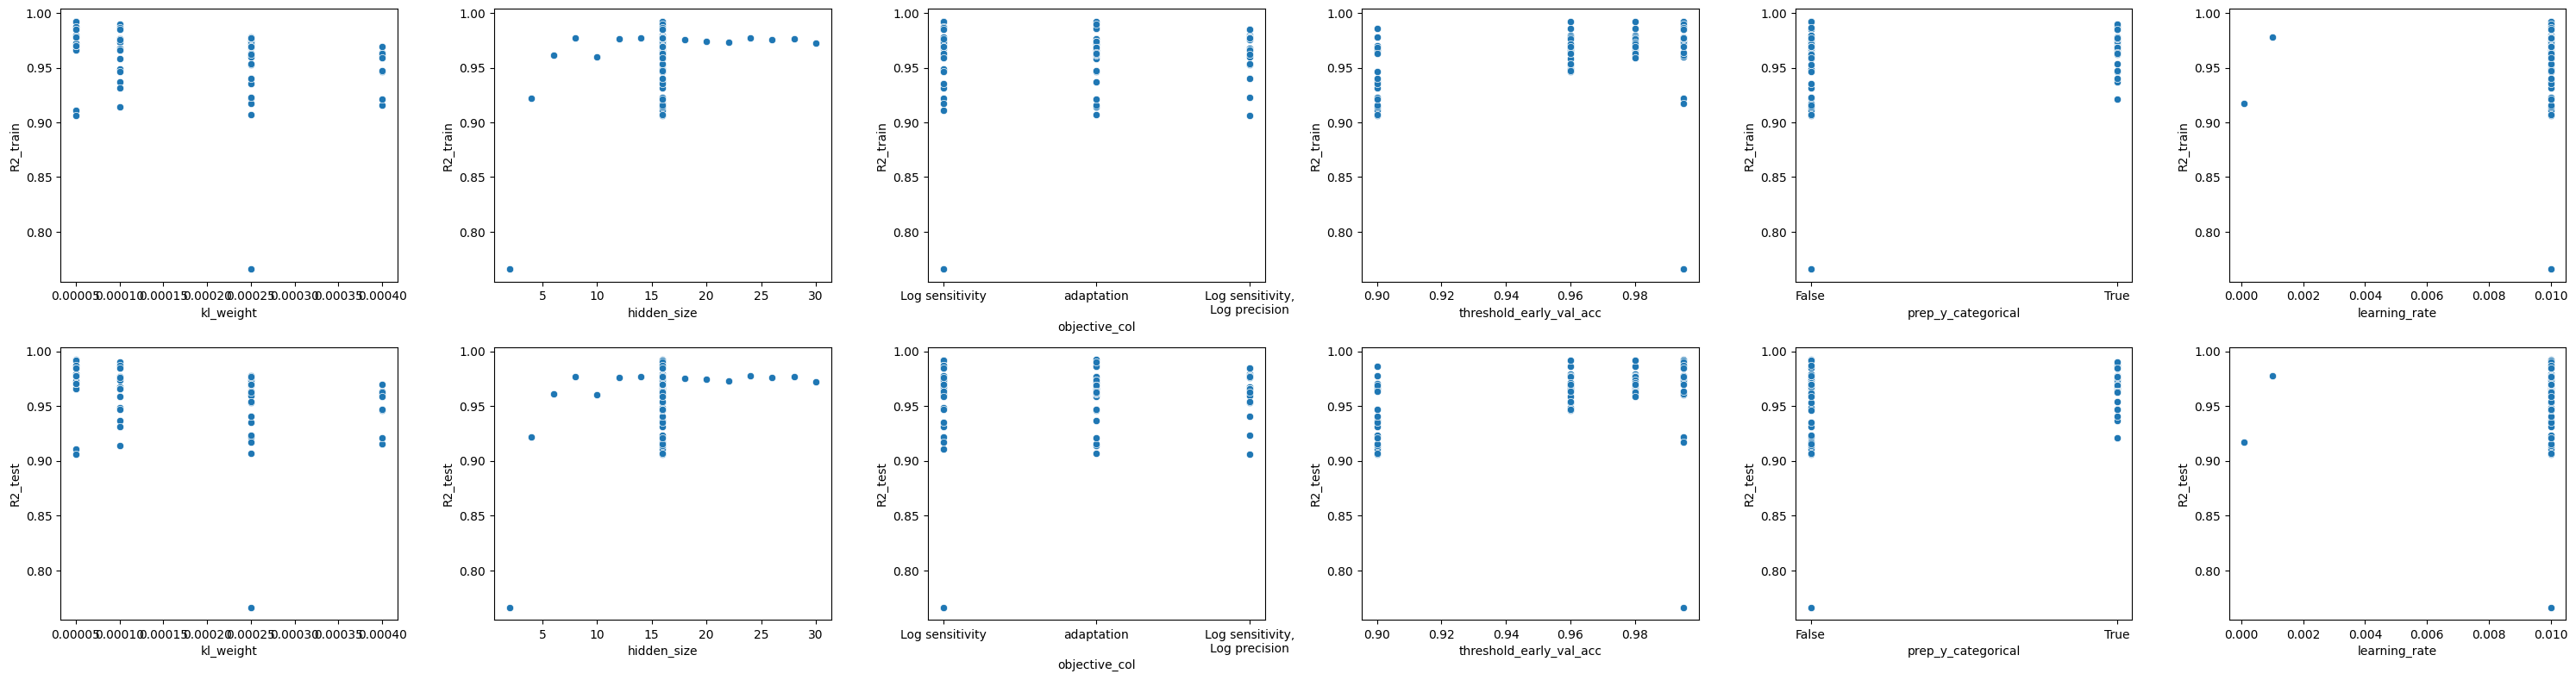

In [6]:
nrows = len(cols_outmetric)
ncols = len(cols_varying)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
j = 0
for j, kj in enumerate(cols_outmetric):
    for i, k in enumerate(cols_varying):
        sns.scatterplot(data=df_hpos, x=k, y=cols_outmetric[j], ax=axes[j, i])
plt.tight_layout()

In [7]:
hpos_to_vary_together = [{
    'objective_col': [('adaptation',), ('Log sensitivity',), ('Log sensitivity', 'Log precision')],
    'prep_y_categorical': [False, True],
    'use_kl_div': [True],
    'kl_weight': [5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4],
    'threshold_early_val_acc': [0.995, 0.98, 0.96, 0.9],
},
    {
    'use_contrastive_loss': [True],
    'temperature': [0.1, 0.5, 1, 1.5, 2, 4, 8],
    'threshold_similarity': [0.95, 0.9, 0.7, 0.5, 0.3, 0.1],
    'power_factor_distance': [3, 4],
    'threshold_early_val_acc': [0.995, 0.9]
}]

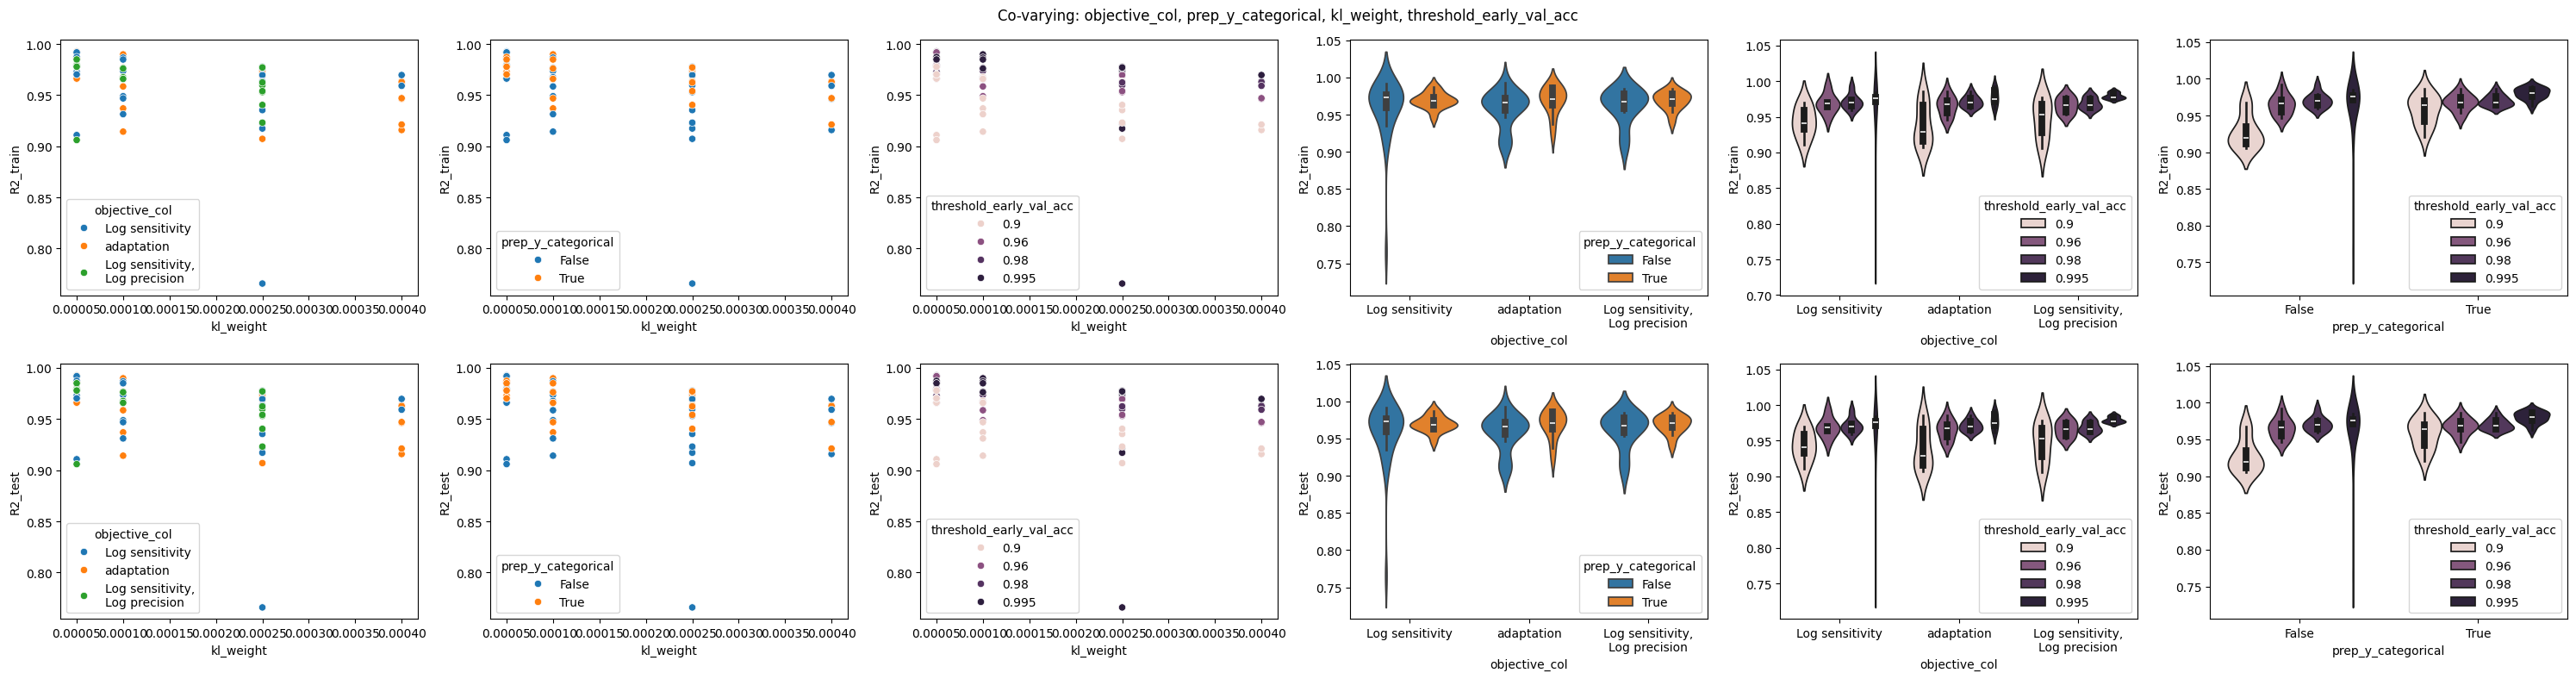

In [8]:
for h in hpos_to_vary_together:
    h_keys = [c for c in h.keys() if df_hpos[c].nunique() > 1]
    combinations = sorted(set([tuple(sorted([i, j])) for i, j in itertools.combinations(h_keys, 2)]))
    ncols = len(combinations)
    nrows = len(cols_outmetric)
    if ncols > 0:
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        for j, kj in enumerate(cols_outmetric):
            for i, (k1, k2) in enumerate(combinations):
                if df_hpos[k1].dtype == object:
                    f = sns.violinplot
                else:
                    f = sns.scatterplot
                f(data=df_hpos, x=k1, y=kj, hue=k2, ax=axes[j, i])
        plt.suptitle('Co-varying: ' + ', '.join(h_keys))
        plt.tight_layout()
        